# 3. Basic model from scratch

## Prerequisites

  - Install Conda and create environment: see notebook *1. Conda setup*
  - Install Poetry and create configuration: see notebook *2. Poetry setup*

Make sure you select the environment (kernel) *NN* to run this notebook. Also activate it in companion terminal:  
`conda activate NN`

Let's check we have Python 3.9 running:

In [1]:
!python --version

Python 3.9.7


Let's make sure packages and dependencies are installed by Poetry:  
```poetry install```

Let's check our packages and dependencies:

In [2]:
!poetry show --tree

matplotlib 3.5.1 Python plotting package
├── cycler >=0.10
├── fonttools >=4.22.0
├── kiwisolver >=1.0.1
├── numpy >=1.17
├── packaging >=20.0
│   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
├── pillow >=6.2.0
├── pyparsing >=2.2.1
├── python-dateutil >=2.7
│   └── six >=1.5 
└── setuptools-scm >=4
    ├── packaging >=20.0 
    │   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
    └── tomli >=1.0.0 
numpy 1.22.1 NumPy is the fundamental package for array computing with Python.
pytest 6.2.5 pytest: simple powerful testing with Python
├── atomicwrites >=1.0
├── attrs >=19.2.0
├── colorama *
├── iniconfig *
├── packaging *
│   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
├── pluggy >=0.12,<2.0
├── py >=1.8.2
└── toml *
torch 1.10.1 Tensors and Dynamic neural networks in Python with strong GPU acceleration
└── typing-extensions *


If we want to update the Conda environment, we can run (in companion terminal):  
```
conda env update --prune -f environment_init.yml
```

If we want to update the Poetry setup, we can run (in companion terminal, making sure NN is activated):  
```
poetry update
```

We can create shortcuts for these actions in a separate **Makefile** (check its contents), which can then be called from a terminal:
```
make conda-udate
make poetry-update
```

## Linear model

Note: This notebook is inspired from https://fullstackdeeplearning.com/spring2021/notebook-1/.

### Generate and visualize data

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Let us create and show a dataset of 20 points:

In [4]:
nb_datapoints = 10
input_dim = 1
x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))
x.sort(axis=0)

Suppose that we want to approximate the 'true' function \bar{f}(x) = x/2 + 1:


In [5]:
output_dim = 1

weights_true = np.random.uniform(-1, 1, (input_dim, output_dim))
bias_true = np.random.uniform(-1, 1, (output_dim,))

y_true = x @ weights_true + bias_true # Matrix multiplication and element-wise addition

Let's inspect all the shapes:

In [6]:
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y_true: {y_true.shape}')

x: (10, 1), weights: (1, 1), bias: (1,), y_true: (10, 1)


Let's plot our true function:

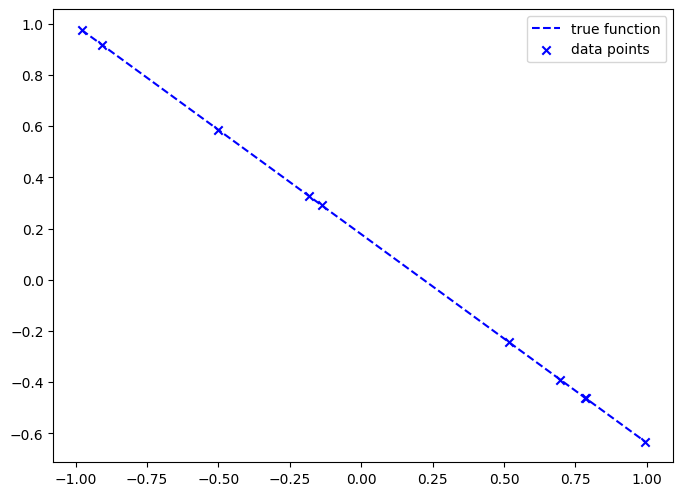

In [7]:
from matplotlib.pyplot import figure


figure(figsize=(8, 6), dpi=100)
plt.plot(x.squeeze(-1), y_true.squeeze(-1), 'b--', label='true function')
plt.scatter(x.squeeze(-1), y_true.squeeze(-1), color='b', marker='x', label='data points')
plt.legend()
plt.show()

### Linear model

Let us define the simplest model: one layer, linear, no activation function. This is equivalent to linear regression.

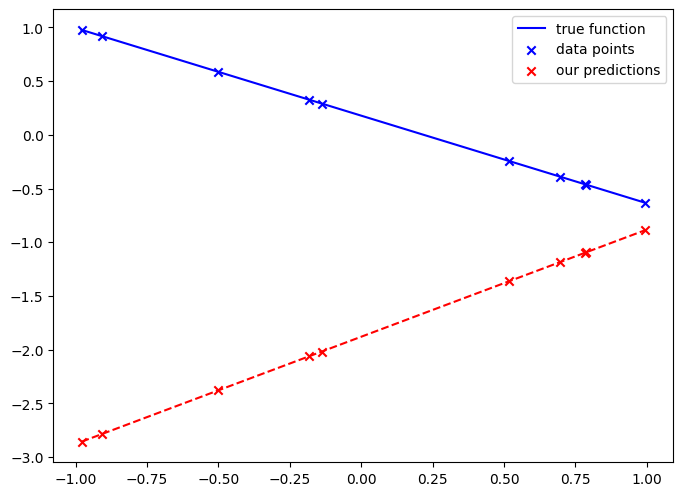

In [8]:
class LinearLayer:
  def __init__(self, input_dim, output_dim):
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(1. / input_dim) # Not sure why FSDL had np.sqrt(2. / input_dim)
    # It is best to think of the weights as a matrix acting on the input (given as a line vector) by multiplication *on the right*
    self.bias = np.random.randn(output_dim) * np.sqrt(1. / input_dim) # FSDL initializes them to zero: np.zeros(output_dim)
  
  def __call__(self, x):
    return x @ self.weights + self.bias
  # Mind that the first dim of x corresponds to the number of data points.
  # In numpy, when doing matrix multiplication, if either argument is N-dimensional, N > 2, 
  # then it is treated as a stack of matrices residing in the last two indexes.

  def forward(self, x):
    self.x = x
    self.y = self(x)
    return self.y

  def backward(self, previous_grad):
    x = self.x # x has shape (nb_datapoints, input_dim) 
    # previous_grad has shape (nb_datapoints, output_dim)
    self.weights_gradient = x.T @ previous_grad # shape (input_dim, output_dim)
    self.bias_gradient = previous_grad.sum(axis=0) # shape (output_dim,)
    self.x_gradient = previous_grad @ self.weights.T # shape (nb_datapoints, input_dim)
    return self.x_gradient

  def update(self, learning_rate):
    self.weights = self.weights - learning_rate*self.weights_gradient
    self.bias = self.bias - learning_rate*self.bias_gradient
    

linear = LinearLayer(1, 1)
y_pred = linear(x)
figure(figsize=(8, 6), dpi=100)
plt.plot(x.squeeze(-1), y_true.squeeze(-1), 'b-', label='true function')
plt.scatter(x.squeeze(-1), y_true.squeeze(-1), color='b', marker='x', label='data points')
plt.plot(x.squeeze(-1), y_pred.squeeze(-1), 'r--')
plt.scatter(x.squeeze(-1), y_pred.squeeze(-1), color='r', marker='x', label='our predictions')
plt.legend()
plt.show()

Basic metric: MSE


In [9]:
class MSE:
  def __call__(self, y, y_true):
    # y and y true have shape (nb_datapoints, output_dim)
    return ((y - y_true) ** 2).sum(axis=1).mean(axis=0)

  def gradient(self, y, y_true):
    nb_datapoints = y.shape[0]
    return 2. * (y - y_true) / nb_datapoints # shape (nb_datapoints, output_dim)
    # Note: We divide by |nb_datapoints| to not have to do it during backpropagation

  
metric = MSE()
print(f'Our initial loss is {metric(y_pred, y_true)}')

Our initial loss is 5.095028565130369


Let's now create our model:

In [10]:
class LinearModel:
    def __init__(self, layer, metric):
        self.layer = layer
        self.metric = metric

    def __call__(self, x):
        return self.layer(x)

    def forward(self, x):
        self.x = x
        self.y = self.layer.forward(self.x)

    def loss(self, x, y_true):
        return self.metric(self(x), y_true)

    def backward(self, y_true, learning_rate):
        gradient = self.metric.gradient(self.y, y_true) # shape (nb_datapoints, output_dim)
        gradient = self.layer.backward(gradient) # shape (nb_datapoints, input_dim)
        self.layer.update(learning_rate)

Let's try it! Observe that the loss decreases after one forward and backward pass.

In [ ]:

def fbar(x):
  return x @ weights_true + bias_true

x = np.random.uniform(-1, 1, (10, 1))
y_true = fbar(x)


linear = LinearLayer(1, 1)
metric = MSE()
model = LinearModel(linear, metric)

print(f"loss = {model.loss(x, y_true)}")

model.forward(x)
model.backward(y_true, 0.1)
print(f"loss = {model.loss(x, y_true)}")

Let's add some bells and whistles:

In [11]:
# We'll use this to shuffle the dataset (and labels accordingly)
def shuffle_sync(*arrs):
    '''Shuffles arrays of the same length according to a same random permutation'''
    seed = np.random.randint(0, 2**(32 - 1) - 1)
    for arr in arrs:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

x = np.arange(10)
y = np.arange(10, 20)
print(x,y)
shuffle_sync(x,y)
print(x,y)

[0 1 2 3 4 5 6 7 8 9] [10 11 12 13 14 15 16 17 18 19]
[1 5 7 3 4 9 0 6 2 8] [11 15 17 13 14 19 10 16 12 18]


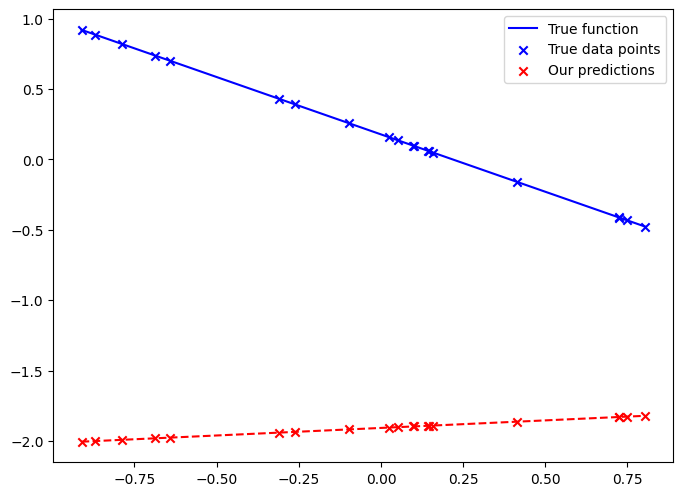

Epoch 1: loss = 0.026386045936350837
Epoch 2: loss = 0.0006806472426355134
Epoch 3: loss = 3.725822141208923e-05
Epoch 4: loss = 2.0821678657476717e-06
Epoch 5: loss = 2.453563919616451e-07
Epoch 6: loss = 1.0893401082973133e-08
Epoch 7: loss = 2.902481904452547e-10
Epoch 8: loss = 2.358485939728646e-11
Epoch 9: loss = 9.206868905937064e-13
Epoch 10: loss = 4.305206678516941e-14


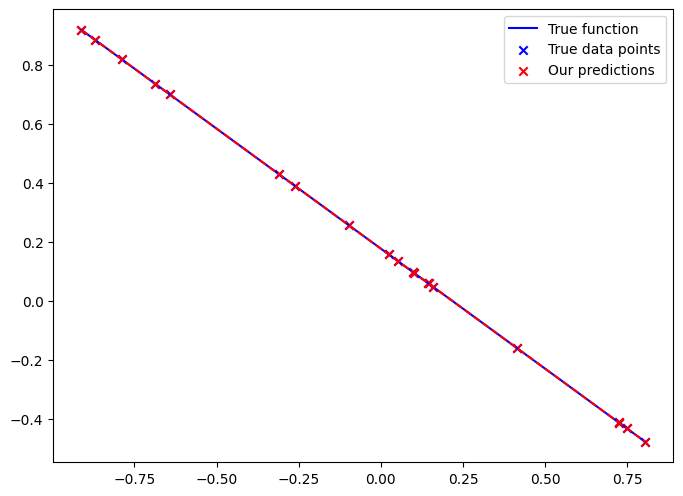

In [12]:
class LinearModel:
    def __init__(self, layer, metric):
        self.layer = layer
        self.metric = metric

    def __call__(self, x):
        return self.layer(x)

    def forward(self, x):
        self.x = x
        self.y = self.layer.forward(x)

    def training_loss(self):
        return self.metric(self(self.x_training), self.y_true_training)

    def backward(self, y_true, learning_rate):
        gradient = self.metric.gradient(self.y, y_true) # shape (nb_datapoints, output_dim)
        gradient = self.layer.backward(gradient) # shape (nb_datapoints, input_dim)
        self.layer.update(learning_rate)

    def set_training_data(self, x_training):
        self.x_training = x_training
        self.nb_datapoints = x_training.shape[0]

    def set_training_labels(self, y_true_training=None, true_function=None):
            assert((y_true_training is None) ^ (true_function is None))
            if true_function:
                y_true_training = true_function(self.x_training)
            self.y_true_training = y_true_training

    def set_training_parameters(self, batch_size=5, learning_rate=0.1):
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def train(self, nb_epochs):
        x_training = np.copy(self.x_training)
        y_true_training = np.copy(self.y_true_training)

        for epoch in range(1, nb_epochs+1):
            shuffle_sync(x_training, y_true_training)

            k=0
            while k < self.nb_datapoints:
                k_next = min(k+self.batch_size, self.nb_datapoints)
                x_batch = x_training[k:k_next]
                y_true_batch = y_true_training[k:k_next]
                self.forward(x_batch)
                self.backward(y_true_batch, self.learning_rate)
                k = k_next

            if epoch % 1 ==0:
                print(f"Epoch {epoch}: loss = {self.training_loss()}")

    def plot(self): # Only works if (input_dim, output_dim) = (1, 1)
        x = self.x_training
        y_pred = model(self.x_training)
        y_true = self.y_true_training

        figure(figsize=(8, 6), dpi=100)
        plt.plot(x, y_true, 'b-', label='True function')
        plt.scatter(x, y_true, color='b', marker='x', label='True data points')
        plt.plot(x.squeeze(-1), y_pred.squeeze(-1), 'r--')
        plt.scatter(x, y_pred, color='r', marker='x', label='Our predictions')
        plt.legend()
        plt.show()

    def plot3d(self):  # Only works if (input_dim, output_dim) = (2, 1)
        x = self.x_training
        y_pred = model(self.x_training)
        y_true = self.y_true_training

        fig = plt.figure(figsize=(8, 6), dpi=100)
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x[:, 0], x[:, 1], y_true, label='True data points')
        ax.scatter(x[:, 0], x[:, 1], y_pred, label='Our predictions')
        plt.legend()
        plt.show()



def fbar(x):
    return x @ weights_true + bias_true

x = np.random.uniform(-1, 1, (20, 1))
x.sort(axis=0)

linear = LinearLayer(1, 1)
metric = MSE()
model = LinearModel(linear, metric)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)


model.plot()
model.train(10)
model.plot()

Let's try to approximate a non-linear function:

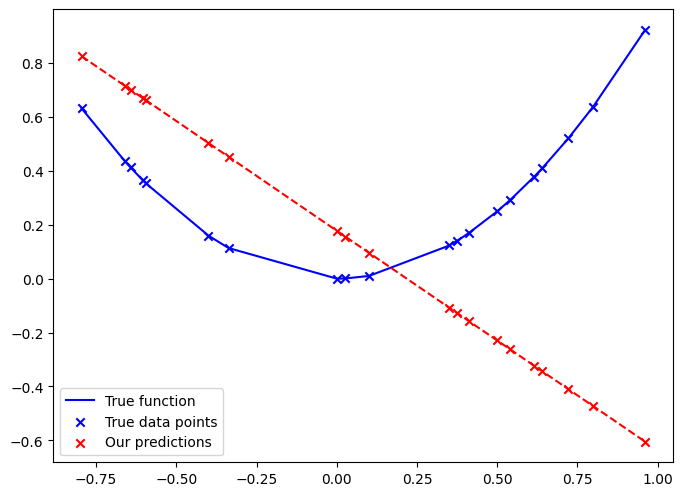

Epoch 1: loss = 0.20081163339678404
Epoch 2: loss = 0.1369292082753554
Epoch 3: loss = 0.10350385486734621
Epoch 4: loss = 0.08401441258002387
Epoch 5: loss = 0.07212520329512084
Epoch 6: loss = 0.06549316243265416
Epoch 7: loss = 0.06071659608756615
Epoch 8: loss = 0.05788259585078952
Epoch 9: loss = 0.05624330911456221
Epoch 10: loss = 0.05526284193279678
Epoch 11: loss = 0.05453203981555671
Epoch 12: loss = 0.054002314787418904
Epoch 13: loss = 0.053753051957414776
Epoch 14: loss = 0.053549349135411206
Epoch 15: loss = 0.05351806975586417
Epoch 16: loss = 0.05343885968556651
Epoch 17: loss = 0.05344092819671379
Epoch 18: loss = 0.053408625365007366
Epoch 19: loss = 0.05363474316554366
Epoch 20: loss = 0.05364230725599557


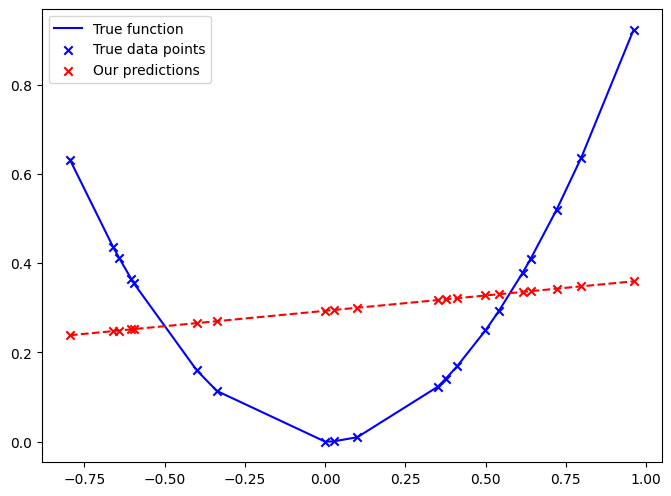

In [13]:
def fbar(x):
    return x ** 2

x = np.random.uniform(-1, 1, (20, 1))
x.sort(axis=0)

model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(learning_rate=0.1)


model.plot()
model.train(20)
model.plot()

### 2-dimensional inputs work too

In [ ]:
nb_datapoints = 100
input_dim = 2
output_dim = 1
x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))

weights_true = np.array([[2, -1], ]).T
bias_true = np.array([0.5])

print(x.shape)
print(weights_true.shape)

def fbar(x):
  return x @ weights_true + bias_true

y_true = fbar(x)

linear = LinearLayer(2, 1)
metric = MSE()
model = LinearModel(linear, metric)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)

model.plot3d()
model.train(3)
model.plot3d()

In [ ]:
def fbar(x):
  return (x**2).sum(axis=1)[..., None]

nb_datapoints = 1000
input_dim = 2
output_dim = 1
x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))

y_true = fbar(x)
print(y_true.shape)

linear = LinearLayer(2, 1)
metric = MSE()
model = LinearModel(linear, metric)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)


model.plot3d()
model.train(10)
model.plot3d()

### Add non-linearity: ReLU

In [14]:
class ReluLayer:  
  def __call__(self, x):
    return np.clip(x, 0, None)

  def forward(self, x):
    self.x = x
    self.y = self(x)
    return self.y

  def backward(self, previous_grad):
    self.gradient = (self.x > 0) * previous_grad
    return self.gradient

  def update(self, learning_rate):
    return




f = ReluLayer()
x1 = np.random.uniform(-1, 1, (3, 2))
print(x1)
print(f(x1))

[[ 0.00619695 -0.87625434]
 [-0.38469275  0.97913476]
 [-0.4902817  -0.70871341]]
[[0.00619695 0.        ]
 [0.         0.97913476]
 [0.         0.        ]]


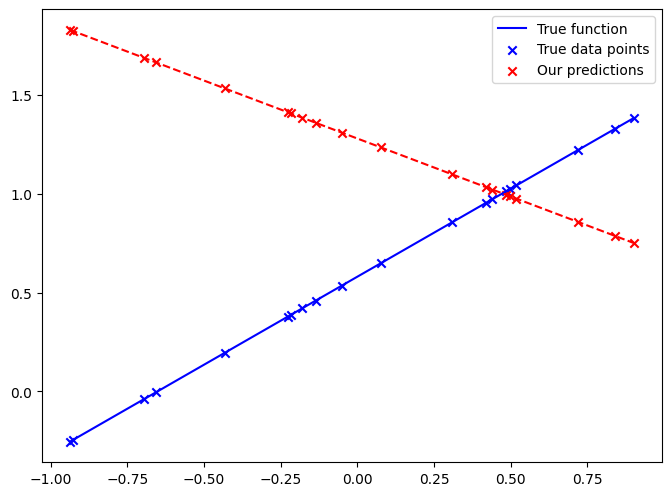

Epoch 1: loss = 0.012448290234586169
Epoch 2: loss = 0.0072314441858532625
Epoch 3: loss = 0.006488414330166885
Epoch 4: loss = 0.006390646755060051
Epoch 5: loss = 0.006354206803447786
Epoch 6: loss = 0.006348104291422614
Epoch 7: loss = 0.006346939263535479
Epoch 8: loss = 0.006346320442468939
Epoch 9: loss = 0.006346158099179061
Epoch 10: loss = 0.0063461203759672055
Epoch 11: loss = 0.006346105475059401
Epoch 12: loss = 0.006346101231066922
Epoch 13: loss = 0.006346099741318313
Epoch 14: loss = 0.006346099280735529
Epoch 15: loss = 0.006346099154759576
Epoch 16: loss = 0.006346099111769174
Epoch 17: loss = 0.006346099100878364
Epoch 18: loss = 0.006346099093989768
Epoch 19: loss = 0.00634609909107293
Epoch 20: loss = 0.00634609909074922


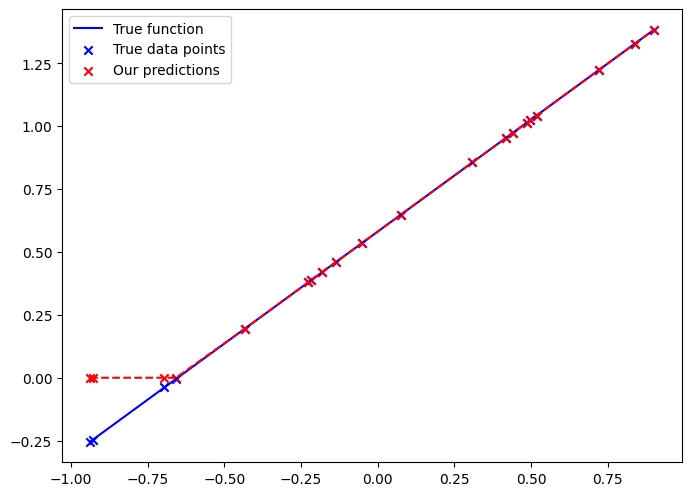

In [15]:
class Model:
    def __init__(self, *layers, metric):
        self.layers = layers
        self.metric = metric

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def forward(self, x):
        for layer in self.layers:
            y = layer.forward(x)
            x = y
        self.y = y
        return y

    def training_loss(self):
        return self.metric(self(self.x_training), self.y_true_training)

    def backward(self, y_true, learning_rate):
        gradient = self.metric.gradient(self.y, y_true)
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
            layer.update(learning_rate)

    def set_training_data(self, x_training):
        self.x_training = x_training
        self.nb_datapoints = x_training.shape[0]

    def set_training_labels(self, y_true_training=None, true_function=None):
            assert((y_true_training is None) ^ (true_function is None))
            if true_function:
                y_true_training = true_function(self.x_training)
            self.y_true_training = y_true_training

    def set_training_parameters(self, batch_size=5, learning_rate=0.1):
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def train(self, nb_epochs):
        x_training = np.copy(self.x_training)
        y_true_training = np.copy(self.y_true_training)

        for epoch in range(1, nb_epochs+1):
            shuffle_sync(x_training, y_true_training)

            k=0
            while k < self.nb_datapoints:
                k_next = min(k+self.batch_size, self.nb_datapoints)
                x_batch = x_training[k:k_next]
                y_true_batch = y_true_training[k:k_next]
                self.forward(x_batch)
                self.backward(y_true_batch, self.learning_rate)
                k = k_next

            if epoch % 1 ==0:
                print(f"Epoch {epoch}: loss = {self.training_loss()}")

    def plot(self): # Only works if (input_dim, output_dim) = (1, 1)
        x = self.x_training
        y_pred = model(self.x_training)
        y_true = self.y_true_training

        figure(figsize=(8, 6), dpi=100)
        plt.plot(x, y_true, 'b-', label='True function')
        plt.scatter(x, y_true, color='b', marker='x', label='True data points')
        plt.plot(x.squeeze(-1), y_pred.squeeze(-1), 'r--')
        plt.scatter(x, y_pred, color='r', marker='x', label='Our predictions')
        plt.legend()
        plt.show()

    def plot3d(self):  # Only works if (input_dim, output_dim) = (2, 1)
        x = self.x_training
        y_pred = model(self.x_training)
        y_true = self.y_true_training

        fig = plt.figure(figsize=(8, 6), dpi=100)
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x[:, 0], x[:, 1], y_true, label='True data points')
        ax.scatter(x[:, 0], x[:, 1], y_pred, label='Our predictions')
        plt.legend()
        plt.show()


nb_datapoints = 20
input_dim = 1
output_dim = 1
weights_true = np.random.uniform(-1, 1, (input_dim, output_dim))
bias_true = np.random.uniform(-1, 1, (output_dim,))

def fbar(x):
    return x @ weights_true + bias_true

x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))
x.sort(axis=0)

lin = LinearLayer(1, 1)
rel = ReluLayer()
met = MSE()
model = Model(lin, rel, metric=met)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)


model.plot()
model.train(20)
model.plot()

Oops! Of course our model cannot produce negative predictions. Like add a second linear layer:

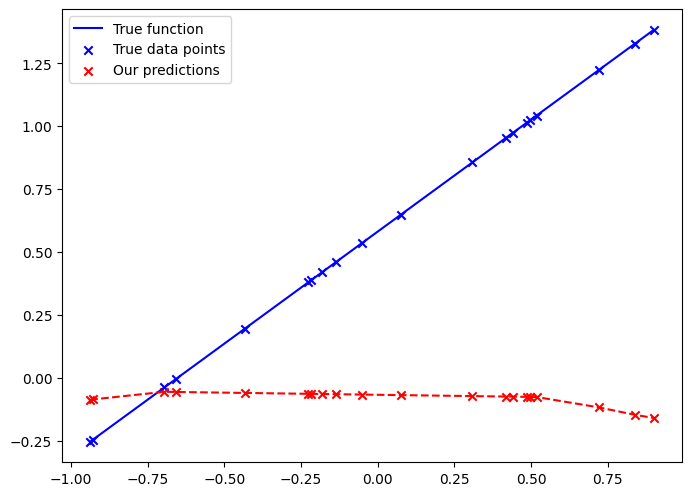

Epoch 1: loss = 0.2565882551628967
Epoch 2: loss = 0.32950893923158964
Epoch 3: loss = 0.04687744863012214
Epoch 4: loss = 0.007652403585418775
Epoch 5: loss = 0.0008114105013977314
Epoch 6: loss = 0.0020003112681576426
Epoch 7: loss = 0.0004949994953017949
Epoch 8: loss = 0.0030354934485299864
Epoch 9: loss = 0.00041452427950891633
Epoch 10: loss = 0.000528845456923571
Epoch 11: loss = 0.0004017752721173079
Epoch 12: loss = 0.0003939853245185264
Epoch 13: loss = 0.0007932883447224615
Epoch 14: loss = 0.00039146189506629415
Epoch 15: loss = 0.0006743435302469985
Epoch 16: loss = 0.0018735362361869527
Epoch 17: loss = 0.0006129043164187621
Epoch 18: loss = 0.00034070401426499847
Epoch 19: loss = 0.0008926193428260345
Epoch 20: loss = 0.0004548878672490108


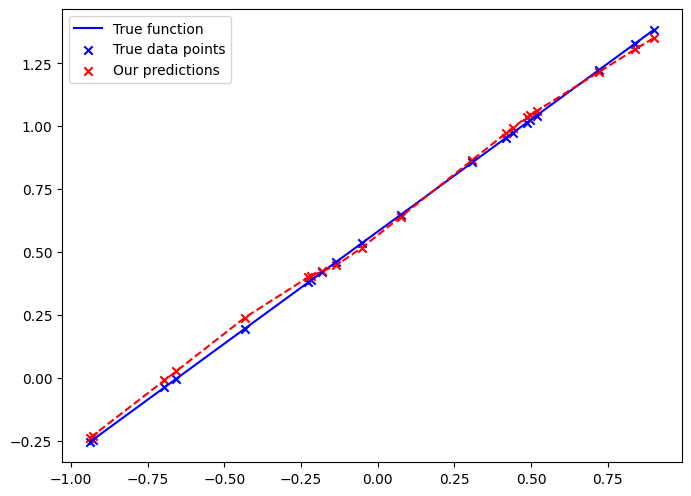

In [16]:
lin1 = LinearLayer(1, 10)
rel1 = ReluLayer()
lin2 = LinearLayer(10, 1)
met = MSE()
model = Model(lin1, rel1, lin2, metric=met)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)


model.plot()
model.train(20)
model.plot()

What about approximating a non-linear function?

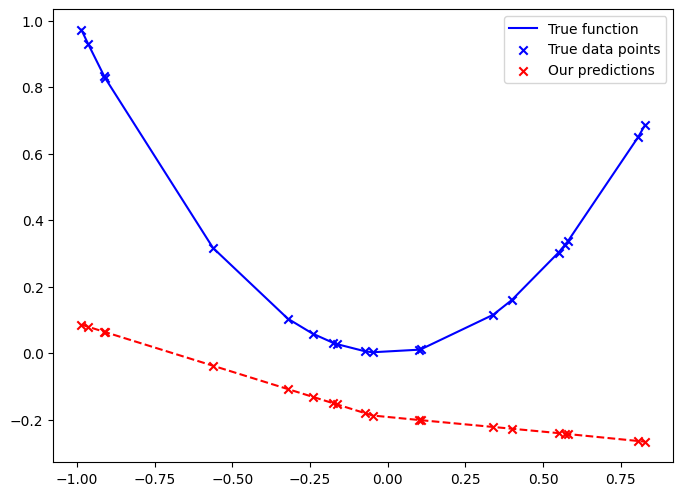

Epoch 1: loss = 0.15907762281456955
Epoch 2: loss = 0.04874190847929526
Epoch 3: loss = 0.043585025927089766
Epoch 4: loss = 0.038306762173183656
Epoch 5: loss = 0.03429316758522584
Epoch 6: loss = 0.031254853818515504
Epoch 7: loss = 0.026980739082711445
Epoch 8: loss = 0.0241270361582121
Epoch 9: loss = 0.019853124546780267
Epoch 10: loss = 0.016696489372005466
Epoch 11: loss = 0.013926872767985928
Epoch 12: loss = 0.011807190877053416
Epoch 13: loss = 0.010487794937446837
Epoch 14: loss = 0.008322343508410664
Epoch 15: loss = 0.0070722145189912435
Epoch 16: loss = 0.0061039830608762575
Epoch 17: loss = 0.00534652223290318
Epoch 18: loss = 0.00466707234321149
Epoch 19: loss = 0.0042991270597315355
Epoch 20: loss = 0.00406424447320233
Epoch 21: loss = 0.0035700438593251143
Epoch 22: loss = 0.0032856101579292847
Epoch 23: loss = 0.003103119866527381
Epoch 24: loss = 0.002903869095706905
Epoch 25: loss = 0.0028146697920397026
Epoch 26: loss = 0.002669178415688591
Epoch 27: loss = 0.0026

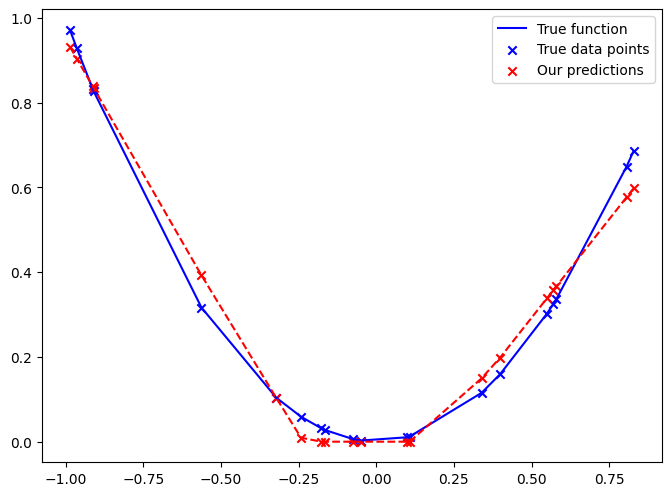

In [36]:
nb_datapoints = 20
input_dim = 1
output_dim = 1
weights_true = np.random.uniform(-1, 1, (input_dim, output_dim))
bias_true = np.random.uniform(-1, 1, (output_dim,))

def fbar(x):
    return x**2

x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))
x.sort(axis=0)

lin1 = LinearLayer(1, 10)
rel1 = ReluLayer()
lin2 = LinearLayer(10, 1)
met = MSE()
model = Model(lin1, rel1, lin2, metric=met)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.2)


model.plot()
model.train(50)
model.plot()

Notice how it's very sensitive to the hyperparameters! For instance, a learning rate >0.2 won't work.

### Same thing, in PyTorch

In [ ]:
import torch
import torch.nn as nn


class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, num_hidden)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(num_hidden, 1)
  
  def forward(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2


loss = nn.MSELoss()
model = TorchModel(d, 10)
x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

In [ ]:
# Test just one forward and backward step
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

optimizer.zero_grad()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss_value.backward()
optimizer.step()

y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

In [ ]:
# Now we run the training loop

def torch_fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred_tensor = model(x_tensor)
    loss_value = loss(y_pred_tensor, y_true_tensor)
    print(loss_value)
    loss_value.backward()
    optimizer.step()

torch_fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, model(x_tensor).detach())

### Same thing, in Tensorflow/Keras

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

inputs = keras.Input(shape=(2,))
l1 = layers.Dense(10, activation='relu', name='dense_1')(inputs)
outputs = layers.Dense(1, name='regression')(l1)

model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())
model.compile(loss='mse', optimizer=optimizers.SGD(0.1))

model.fit(x, y_true, epochs=10)

y_pred = model.predict(x)

plot_3d(x, y_true, model(x))